## 12.2 넘파이처럼 텐서플로 사용하기

### 12.2.1 텐서와 연산

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
tf.constant([[1.,2.,3.],[4.,5.,6.]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [4]:
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [5]:
t = tf.constant([[1.,2.,3.],[4.,5.,6.]])
t.shape

TensorShape([2, 3])

In [7]:
t.dtype

tf.float32

In [9]:
t[:,1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [10]:
t[...,1,tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

t + 10 = tf.add(t,10) 또는 t.__ add __ (10)

In [11]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [12]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

tf.matmul()함수와 동일

In [13]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

#### 케라스의 저수준 API

In [15]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### 12.2.2 텐서와 넘파이

In [16]:
a = np.array([2.,4.,5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [17]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [18]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [19]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### 12.2.3 타입 변환

In [21]:
try :
    tf.constant(2.) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [23]:
try :
    tf.constant(2.) + tf.constant(40., dtype = tf.float64)
except tf.errors.InvalidArgumentError as ex:
        print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [24]:
t2 = tf.constant(40., dtype = tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

12.2.4 변수

In [25]:
v = tf.Variable([[1.,2.,3.],[4.,5.,6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [26]:
v.assign(2*v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [27]:
v[0,1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [28]:
v[:,2].assign([0.,1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [29]:
v.scatter_nd_update(indices=[[0,0],[1,2]], updates=[100.,200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

## 12.3 사용자 정의 모델과 훈련 알고리즘

### 12.3.1 사용자 정의 손실 함수

In [30]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf. square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [31]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

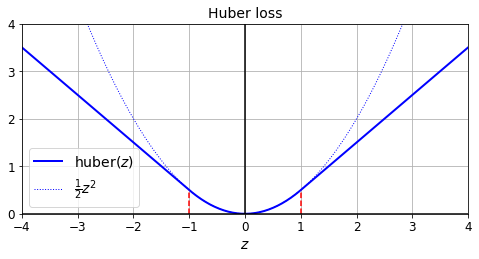

In [32]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [33]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [35]:
model.compile(loss=huber_fn, optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.6235 - val_loss: 0.2862
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2197 - val_loss: 0.2382


### 12.3.2 사용자 정의 요소를 가진 모델을 저장하고 로드하기

In [37]:
model.save("my_model_with_a_custom_loss.h5")

In [38]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                               custom_objects={"huber_fn" : huber_fn})

In [40]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled,y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2054 - val_loss: 0.2209
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1999 - val_loss: 0.2127


In [51]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf. square(error) / 2
        linear_loss = tf.abs(error) - threshold**2/2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [52]:
model.compile(loss=create_huber(2.0), optimizer="nadam",metrics=["mae"])

In [53]:
model.fit(X_train_scaled, y_train, epochs=2,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.1810 - mae: 0.4871 - val_loss: 0.1913 - val_mae: 0.4890
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1776 - mae: 0.4819 - val_loss: 0.1886 - val_mae: 0.4871


In [55]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [56]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                               custom_objects = {"huber_fn": create_huber(2.0)})

In [57]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1759 - mae: 0.4778 - val_loss: 0.1752 - val_mae: 0.4683
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1737 - mae: 0.4739 - val_loss: 0.1730 - val_mae: 0.4678


In [58]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [59]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [60]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [61]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))


Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.7095 - mae: 0.8863 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2416 - mae: 0.5083 - val_loss: 0.2660 - val_mae: 0.5089


In [62]:
model.save("my_model_with_a_custom_loss_class.h5")

In [63]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [64]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2286 - mae: 0.4970 - val_loss: 0.2120 - val_mae: 0.4723
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2216 - mae: 0.4904 - val_loss: 0.2045 - val_mae: 0.4725


In [65]:
model.loss.threshold

2.0

### 12.3.3 활성화 함수, 초기화, 규제, 제한을 커스터마이징하기

In [68]:
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / shape[0] + shape[1])
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [69]:
layer = keras.layers.Dense(30, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer,
                          kernel_constraint=my_positive_weights)

In [71]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self,weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

### 12.3.4 사용자 정의 지표

스트리밍 지표

In [75]:
precision = keras.metrics.Precision()
precision([0,1,1,1,0,1,0,1],[1,1,0,1,0,1,0,1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [76]:
precision([0,1,0,0,1,0,1,1],[1,0,1,1,0,0,0,0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [77]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [78]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [80]:
precision.reset_states() #두 변수가 0.0으로 리셋된다

스트리밍 지표 만들기

In [83]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # 기본 매개변수 처리(예, dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true,y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        return{**base_config, "threshold": self.threshold}

### 12.3.5 사용자 정의 층

In [84]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [85]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [86]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # 사용자 정의 층 디버깅
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [87]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

### 12.3.6 사용자 정의 모델

In [88]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self,n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons,activation="elu",
                                         kernel_initializer="he_normal")
                      for _ in range(n_layers)]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layers(Z)
        return inputs + Z

In [89]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

### 12.3.7 모델 구성 요소에 기반한 손실과 지표

노트: 다음 코드는 책의 코드와 두 가지 다른 점이 있습니다:

1. 생성자에서 keras.metrics.Mean() 측정 지표를 만들고 call() 메서드에서 사용하여 평균 재구성 손실을 추적합니다. 훈련에서만 사용해야 하기 때문에 call() 메서드에 training 매개변수를 추가합니다. training이 True이면 reconstruction_mean를 업데이트하고 self.add_metric()를 호출합니다.
2. TF 2.2에 있는 이슈(#46858) 때문에 build() 메서드 안에서 super().build()를 호출하면 안됩니다.

In [90]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        self.recon_loss = 0.05 * tf.reduce_mean(tf.square(reconstruction - inputs))
        
        if training:
           result = self.reconstruction_mean(recon_loss)
           self.add_metric(result)
        return self.out(Z)
    
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred, regularization_losses=[self.recon_loss])

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {m.name: m.result() for m in self.metrics}

### 12.3.8 자동 미분을 사용하여 그레이디언트 계산하기

In [91]:
def f(w1, w2):
    return 3 * w1**2 + 2*w1*w2

In [92]:
w1, w2 = 5,3
eps = 1e-6
(f(w1+eps, w2) - f(w1,w2)) / eps

36.000003007075065

In [93]:
(f(w1, w2+eps) - f(w1,w2)) / eps

10.000000003174137

In [94]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [95]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [96]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [97]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [98]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [99]:
gradients

[None, None]

- gradient() 메서드가 호출된 후에는 자동으로 테이프가 지워짐.
- 두 번 호출 시 예외 발생
- 한 번 이상 호출해야 한다면 지속 가능한 테이프를 만들고 사용이 끝난 후 테이프를 삭제하여 리소스를 해제해야한다.

In [100]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [101]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [103]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [104]:
gradients

[None, None]

In [106]:
# 강제 반환
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [107]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [108]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [109]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [110]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [111]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [112]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [113]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [114]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [115]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

### 12.3.9 사용자 정의 훈련 반복

In [116]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [117]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [118]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [119]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [120]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


In [121]:
# A fancier version with a progress bar:

def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [122]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [123]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [124]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 - mean: 0.6440 - mean_absolute_error: 0.5222


## 12.4 텐서플로 함수와 그래프

In [126]:
def cube(x):
    return x**3

In [128]:
cube(2)

8

In [129]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [130]:
tf_cube = tf.function(cube)
tf_cube

In [131]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [132]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [134]:
@tf.function
def tf_cube(x):
    return x**3

In [135]:
tf_cube.python_function(2)

8